This notebook performs downstream Drug Response Prediction with the augmented patient data from GANs and patient datasets. Uses a neural network to perform DRP.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [3]:
import sys
sys.path.append("../src/tab_ddpm/")

In [4]:
device = torch.device("cuda:0")

In [5]:
torch.manual_seed(0)

In [6]:
sample_id = 2

#### Load Datasets

In [7]:
tcga_train_df = pd.read_csv(f"../data/diffusion_pretraining/tcga_diffusion_train_sample{sample_id}.csv", index_col=0)
tcga_train_df.shape

(476, 7776)

In [8]:
tcga_test_df = pd.read_csv(f"../data/diffusion_pretraining/tcga_diffusion_test_sample{sample_id}.csv", index_col=0)
tcga_test_df.shape

(120, 7776)

In [9]:
# augmented_tcga_df = pd.read_csv(f"/data/ajayago/druid/intermediate/cs6220/baselines/augmented_gan_tcga_sample{sample_id}.csv", index_col = 0)
# augmented_tcga_df = pd.read_csv(f"/data/ajayago/druid/intermediate/cs6220/baselines/augmented_wgan_gp_tcga_sample{sample_id}.csv", index_col = 0)
augmented_tcga_df = pd.read_csv(f"/data/ajayago/druid/intermediate/cs6220/baselines/augmented_attgan_tcga_sample{sample_id}.csv", index_col = 0)
print(augmented_tcga_df.shape)
augmented_tcga_df

(476, 7776)


,ABL1_piu_max,ACVR1B_piu_max,AKT1_piu_max,AKT2_piu_max,AKT3_piu_max,ALK_piu_max,ALOX12B_piu_max,APC_piu_max,AR_piu_max,ARAF_piu_max,...,U2AF1_benign_count,VEGFA_benign_count,VHL_benign_count,WHSC1_benign_count,WHSC1L1_benign_count,WT1_benign_count,XPO1_benign_count,XRCC2_benign_count,ZNF217_benign_count,ZNF703_benign_count
submitter_id,,,,,,,,,,,,,,,,,,,,,
TCGA-FD-A5C1,-0.054035,-0.097066,0.018777,-0.029489,0.009348,-0.013619,0.001816,-0.017962,0.030678,0.001644,...,0.038776,-0.005990,-0.089274,-0.115090,0.065146,0.056107,0.016978,-0.037682,0.018879,0.075362
TCGA-EA-A3QD,-0.214933,-0.259614,0.123268,-0.203576,-0.021721,-0.054969,0.017563,0.030512,0.313880,-0.141719,...,0.185002,-0.016251,-0.195652,-0.332616,0.168702,0.175096,0.219093,-0.058442,-0.097919,0.217254
TCGA-AY-A8YK,-0.002129,-0.049700,0.019667,0.073259,0.009714,0.006880,0.018183,-0.043439,-0.012624,0.095432,...,0.001369,-0.031306,-0.016111,0.007984,0.019939,-0.045249,0.003646,0.024935,0.024522,0.004798
TCGA-E6-A8L9,-0.070847,-0.135122,0.043340,-0.154114,-0.053521,-0.050225,0.052331,-0.090626,0.128349,-0.074975,...,0.055639,-0.084618,-0.080230,-0.145170,-0.006099,0.055070,0.069866,-0.038902,0.009768,0.144387
TCGA-EE-A2M5,-0.060299,-0.237779,-0.005652,-0.152552,-0.082304,-0.020419,0.013584,-0.010704,0.179072,-0.079832,...,0.031675,-0.044317,-0.057010,-0.162955,0.107310,0.148789,0.065999,0.018789,-0.074302,0.131065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-Q1-A5R3,-0.097796,-0.076950,0.034970,0.029505,-0.007574,-0.017612,0.021432,0.006878,0.114943,-0.034824,...,0.102924,-0.072050,-0.099939,-0.147240,0.090896,0.054262,0.082544,-0.032243,0.005229,0.067048
TCGA-IR-A3LA,0.000769,-0.047356,0.022740,0.076580,-0.007863,0.029791,0.013119,-0.031095,-0.010309,0.079120,...,0.011596,-0.011160,0.006351,0.003723,0.025514,-0.054995,-0.002824,0.032264,0.025050,-0.000390
TCGA-AA-3713,-0.022896,-0.093643,0.035347,0.112410,-0.016861,0.004232,0.038224,-0.083701,0.043007,0.140789,...,-0.027946,-0.015710,-0.000179,0.028404,0.024025,-0.129392,0.003703,0.067855,0.037894,0.017403


#### Load response files

In [10]:
cl_responses_df = pd.read_csv("/data/ajayago/copied_from_cdal1/yiming_data_folder/dataset/CellLine/patient_auc.csv")
cl_responses_df

,depmap_id,drug_name,auc
0,ACH-000001,JW-7-24-1,0.778432
1,ACH-000002,JW-7-24-1,0.788327
2,ACH-000004,JW-7-24-1,0.737630
3,ACH-000006,JW-7-24-1,0.176396
4,ACH-000007,JW-7-24-1,0.569751
...,...,...,...
226791,ACH-001702,SL 0101-1,0.958591
226792,ACH-001703,SL 0101-1,0.497201
226793,ACH-001711,SL 0101-1,0.815928
226794,ACH-001715,SL 0101-1,0.981441


In [11]:
patient_responses_df = pd.read_csv("/data/ajayago/copied_from_cdal1/ajayago_home_folder/processed/TCGA_drug_response_010222.csv")
patient_responses_df

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EC,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EC,Doxorubicin,Partial Response,1,DOXORUBICIN
2,TCGA-G2-A2EC,Vinblastine,Partial Response,1,VINBLASTINE
3,TCGA-G2-A2EC,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-G2-A2EJ,Paclitaxel,Stable Disease,0,PACLITAXEL
...,...,...,...,...,...
1244,TCGA-BG-A0VZ,Cisplatin,Complete Response,1,CISPLATIN
1245,TCGA-BG-A0VZ,Paclitaxel,Complete Response,1,PACLITAXEL
1246,TCGA-BG-A0VZ,Doxorubicin,Complete Response,1,DOXORUBICIN
1247,TCGA-BG-A0VT,Carboplatin,Complete Response,1,CARBOPLATIN


In [12]:
patient_responses_df["drug"].value_counts()

drug
CISPLATIN             206
5-FLUOROURACIL        125
CARBOPLATIN           117
PACLITAXEL            113
CYCLOPHOSPHAMIDE       69
                     ... 
E7389                   1
CARMUSTINE              1
TEMOZOLOMIDE            1
ERIBULIN                1
METHYLPREDNISOLONE      1
Name: count, Length: 69, dtype: int64

In [13]:
patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_test_df.index)].drug.value_counts()

drug
CISPLATIN           39
PACLITAXEL          34
5-FLUOROURACIL      29
CARBOPLATIN         27
CYCLOPHOSPHAMIDE    18
LEUCOVORIN          18
DOXORUBICIN         14
DOCETAXEL           13
GEMCITABINE         12
ETOPOSIDE            9
OXALIPLATIN          9
VINORELBINE          7
CAPECITABINE         6
CETUXIMAB            5
PEMETREXED           5
IRINOTECAN           4
EPIRUBICIN           4
ANASTROZOLE          3
METHOTREXATE         2
ERLOTINIB            2
TRASTUZUMAB          2
VINBLASTINE          2
TAMOXIFEN            2
GOSERELIN            1
FULVESTRANT          1
LETROZOLE            1
TOPOTECAN            1
FOTEMUSTINE          1
LOMUSTINE            1
DACARBAZINE          1
VEMURAFENIB          1
DIDOX                1
MITOMYCIN-C          1
Name: count, dtype: int64

In [14]:
patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_train_df.index)].drug.value_counts()

drug
CISPLATIN             167
5-FLUOROURACIL         96
CARBOPLATIN            90
PACLITAXEL             79
CYCLOPHOSPHAMIDE       51
                     ... 
PNU-159548              1
RESIQUIMOD              1
ERIBULIN                1
METHYLPREDNISOLONE      1
TOPOTECAN               1
Name: count, Length: 68, dtype: int64

In [15]:
train_tcga_with_response = patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_train_df.index)].reset_index(drop=True)
train_tcga_with_response

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EC,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EC,Doxorubicin,Partial Response,1,DOXORUBICIN
2,TCGA-G2-A2EC,Vinblastine,Partial Response,1,VINBLASTINE
3,TCGA-G2-A2EC,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-G2-A2EJ,Paclitaxel,Stable Disease,0,PACLITAXEL
...,...,...,...,...,...
968,TCGA-E6-A8L9,Carboplatin,Complete Response,1,CARBOPLATIN
969,TCGA-2E-A9G8,Paclitaxel,Complete Response,1,PACLITAXEL
970,TCGA-2E-A9G8,Carboplatin,Complete Response,1,CARBOPLATIN
971,TCGA-BG-A0VT,Carboplatin,Complete Response,1,CARBOPLATIN


In [16]:
test_tcga_with_response = patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_test_df.index)].reset_index(drop=True)
test_tcga_with_response

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EF,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EF,Vinblastine,Partial Response,1,VINBLASTINE
2,TCGA-G2-A2EF,Doxorubicin,Partial Response,1,DOXORUBICIN
3,TCGA-G2-A2EF,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-DK-A3IQ,Gemcitabine,Stable Disease,0,GEMCITABINE
...,...,...,...,...,...
271,TCGA-QS-A8F1,Carboplatin,Clinical Progressive Disease,0,CARBOPLATIN
272,TCGA-QS-A8F1,Paclitaxel,Clinical Progressive Disease,0,PACLITAXEL
273,TCGA-BG-A0VZ,Cisplatin,Complete Response,1,CISPLATIN
274,TCGA-BG-A0VZ,Paclitaxel,Complete Response,1,PACLITAXEL


In [17]:
drug_fp = pd.read_csv("/data/ajayago/copied_from_cdal1/ajayago_home_folder/processed/drug_morgan_fingerprints.csv", index_col = 0)
drug_fp

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
drug_name,,,,,,,,,,,,,,,,,,,,,
JW-7-24-1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KIN001-260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NSC-87877,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
GNE-317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NAVITOCLAX,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LGH447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRASTUZUMAB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WNT974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
set(train_tcga_with_response["drug"]) - set(drug_fp.index)

{'ALDESLEUKIN',
 'ANASTROZOLE',
 'BCG',
 'CAPECITABINE',
 'CARBOPLATIN',
 'CYCLOSPORINE',
 'DEXAMETHASONE',
 'DIDOX',
 'E7389',
 'ERIBULIN',
 'EXEMESTANE',
 'FOLFIRI',
 'FOLFOX',
 'FOTEMUSTINE',
 'GOSERELIN',
 'GP100',
 'HYDROCORTISONE',
 'IFOSFAMIDE',
 'LETROZOLE',
 'LEUCOVORIN',
 'LEUPROLIDE',
 'LOMUSTINE',
 'MELPHALAN',
 'METHYLPREDNISOLONE',
 'MYCOPHENOLIC ACID',
 'ONDANSETRON',
 'PAMIDRONATE',
 'PEGFILGRASTIM',
 'PNU-159548',
 'PX-866',
 'REGORAFENIB',
 'RESIQUIMOD',
 'TOREMIFENE',
 'VEMURAFENIB'}

In [19]:
set(test_tcga_with_response["drug"]) - set(drug_fp.index)

{'ANASTROZOLE',
 'CAPECITABINE',
 'CARBOPLATIN',
 'DIDOX',
 'FOTEMUSTINE',
 'GOSERELIN',
 'LETROZOLE',
 'LEUCOVORIN',
 'LOMUSTINE',
 'VEMURAFENIB'}

Plan:

* Baseline: Train a model on train patient data + drug fingerprints and predict the response for the (patient, drug) pair.
* Add all cell lines and assign pseudo labels using the patient model from baseline - concat both datasets and train another model.
* Weak supervision + subset selection on cell lines - use this with patient data to train another model

Evaluation: Classification metrics on the patient test dataset.

In [20]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

In [21]:
# Held out TCGA dataset
test_features = []
test_y = []
drugs = []
for idx, row in test_tcga_with_response.iterrows():
    if row["drug"] in drug_fp.index:
        row_inp = []
        row_inp.extend(tcga_test_df.loc[row["patient.arr"]].values)
        row_inp.extend(drug_fp.loc[row["drug"]].values)
        test_y.append(row["response_cat"])
        test_features.append(row_inp)
        drugs.append(row["drug"])

In [22]:
test_features_tensor = torch.tensor(test_features)
test_y_tensor = torch.tensor(test_y)
print(test_features_tensor.shape, test_y_tensor.shape)

torch.Size([216, 9824]) torch.Size([216])


#### Baseline Model

In [23]:
train_features_all = []
train_y_all = []
for idx, row in train_tcga_with_response.iterrows():
    if row["drug"] in drug_fp.index:
        row_inp = []
        row_inp.extend(tcga_train_df.loc[row["patient.arr"]].values)
        row_inp.extend(drug_fp.loc[row["drug"]].values)
        train_y_all.append(row["response_cat"])
        train_features_all.append(row_inp)

In [24]:
val_features = train_features_all[int(0.8 * len(train_features_all)):]
val_y = train_y_all[int(0.8 * len(train_features_all)):]
train_features = train_features_all[:int(0.8 * len(train_features_all))]
train_y = train_y_all[:int(0.8 * len(train_features_all))]

In [25]:
len(train_features), len(test_features), len(val_features)

(596, 216, 150)

In [26]:
train_features_tensor = torch.tensor(train_features)
train_y_tensor = torch.tensor(train_y)
print(train_features_tensor.shape, train_y_tensor.shape)

torch.Size([596, 9824]) torch.Size([596])


In [27]:
val_features_tensor = torch.tensor(val_features)
val_y_tensor = torch.tensor(val_y)
print(val_features_tensor.shape, val_y_tensor.shape)

torch.Size([150, 9824]) torch.Size([150])


In [28]:
class BaseLineNN(nn.Module):
    def __init__(self, in_dim = 9824, hidden_size=64, out_dim = 1):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = nn.ReLU()(x)
        x = self.linear2(x)
        return x

In [29]:
nn_baseline = BaseLineNN()

In [30]:
criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(nn_baseline.parameters(), lr = 1e-3)

In [31]:
train_y_tensor.dtype

torch.int64

In [32]:
# training 
train_losses = []
for i in range(100):
    optim.zero_grad()
    y_pred = nn_baseline(train_features_tensor.to(dtype=torch.float32))
    loss = criterion(y_pred, train_y_tensor.view(-1, 1).to(dtype=torch.float32))
    loss.backward()
    optim.step()

    with torch.no_grad():
        val_loss = criterion(nn_baseline(val_features_tensor.to(dtype=torch.float32)), val_y_tensor.view(-1, 1).to(dtype=torch.float32))

    print(f"Epoch {i}: Training loss: {loss.detach().item()} |  Validation loss: {val_loss.detach().item()}")
    train_losses.append(loss.detach().item())

Epoch 0: Training loss: 0.7071214914321899 |  Validation loss: 0.6650648713111877
Epoch 1: Training loss: 0.7115353941917419 |  Validation loss: 0.6527093052864075
Epoch 2: Training loss: 0.6750816702842712 |  Validation loss: 0.647904098033905
Epoch 3: Training loss: 0.6304271817207336 |  Validation loss: 0.6620051860809326
Epoch 4: Training loss: 0.6353586912155151 |  Validation loss: 0.6603531241416931
Epoch 5: Training loss: 0.6251766085624695 |  Validation loss: 0.6472169756889343
Epoch 6: Training loss: 0.6025330424308777 |  Validation loss: 0.6394056081771851
Epoch 7: Training loss: 0.5830768942832947 |  Validation loss: 0.6390070915222168
Epoch 8: Training loss: 0.5808665752410889 |  Validation loss: 0.6407021284103394
Epoch 9: Training loss: 0.5724136829376221 |  Validation loss: 0.6440936326980591
Epoch 10: Training loss: 0.5548773407936096 |  Validation loss: 0.6525616645812988
Epoch 11: Training loss: 0.5399544835090637 |  Validation loss: 0.6620950698852539
Epoch 12: Train

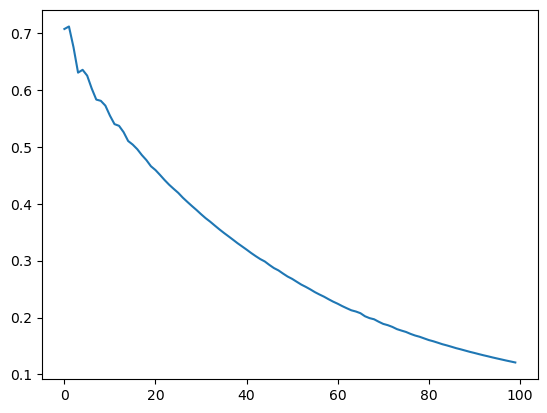

In [33]:
plt.plot(train_losses)

In [34]:
# inference
nn_baseline.eval()
y_test_pred = nn.Sigmoid()(nn_baseline(test_features_tensor.to(dtype=torch.float32)))
y_test_pred.shape

torch.Size([216, 1])

In [35]:
predictions = y_test_pred.detach().numpy().reshape(-1)
predictions.shape

(216,)

In [36]:
auroc = roc_auc_score(test_y, predictions)
auprc = average_precision_score(test_y, predictions)
print(f"AUROC: {auroc}, AUPRC: {auprc}")

AUROC: 0.46145789694176786, AUPRC: 0.6975902994996962


In [37]:
# per drug
res_df = pd.DataFrame(predictions, columns=["y_pred"])
res_df["y_true"] = test_y
res_df["drug"] = drugs

In [38]:
res_df.y_true.value_counts()

y_true
1    154
0     62
Name: count, dtype: int64

In [39]:
for d in res_df.drug.unique():
    try:
        subset_df = res_df[res_df.drug == d]
        auroc = roc_auc_score(subset_df["y_true"], subset_df["y_pred"])
        auprc = average_precision_score(subset_df["y_true"], subset_df["y_pred"])
        print(f"Drug {d} | AUROC = {auroc}, AUPRC = {auprc}")
        print(subset_df.shape)
        print(subset_df.y_true.value_counts())
    except:
        continue

Drug METHOTREXATE | AUROC = 1.0, AUPRC = 1.0
(2, 3)
y_true
1    1
0    1
Name: count, dtype: int64
Drug VINBLASTINE | AUROC = 1.0, AUPRC = 1.0
(2, 3)
y_true
1    1
0    1
Name: count, dtype: int64
Drug DOXORUBICIN | AUROC = 0.4545454545454546, AUPRC = 0.8431164794801158
(14, 3)
y_true
1    11
0     3
Name: count, dtype: int64
Drug CISPLATIN | AUROC = 0.41379310344827586, AUPRC = 0.7640010714688401
(39, 3)
y_true
1    29
0    10
Name: count, dtype: int64
Drug GEMCITABINE | AUROC = 0.38888888888888884, AUPRC = 0.5590909090909091
(12, 3)
y_true
0    6
1    6
Name: count, dtype: int64
Drug PACLITAXEL | AUROC = 0.45333333333333337, AUPRC = 0.712004256827989
(34, 3)
y_true
1    25
0     9
Name: count, dtype: int64
Drug 5-FLUOROURACIL | AUROC = 0.4, AUPRC = 0.6872551026221103
(29, 3)
y_true
1    20
0     9
Name: count, dtype: int64
Drug CYCLOPHOSPHAMIDE | AUROC = 0.59375, AUPRC = 0.936721040397511
(18, 3)
y_true
1    16
0     2
Name: count, dtype: int64
Drug DOCETAXEL | AUROC = 0.524999999999

#### Model with all TCGA patients + pseudo labels and train patient data -- FOCUS

In [40]:
train_tcga_with_response

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EC,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EC,Doxorubicin,Partial Response,1,DOXORUBICIN
2,TCGA-G2-A2EC,Vinblastine,Partial Response,1,VINBLASTINE
3,TCGA-G2-A2EC,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-G2-A2EJ,Paclitaxel,Stable Disease,0,PACLITAXEL
...,...,...,...,...,...
968,TCGA-E6-A8L9,Carboplatin,Complete Response,1,CARBOPLATIN
969,TCGA-2E-A9G8,Paclitaxel,Complete Response,1,PACLITAXEL
970,TCGA-2E-A9G8,Carboplatin,Complete Response,1,CARBOPLATIN
971,TCGA-BG-A0VT,Carboplatin,Complete Response,1,CARBOPLATIN


In [41]:
tcga_aug_train_features = []
tcga_aug_train_y = []
for idx, row in train_tcga_with_response.iterrows():
    if row["drug"] in drug_fp.index:
        # from augmented train data - reuse labels
        row_inp = []
        row_inp.extend(augmented_tcga_df.loc[row["patient.arr"]].values)
        row_inp.extend(drug_fp.loc[row["drug"]].values)
        tcga_aug_train_y.append(row["response_cat"])
        tcga_aug_train_features.append(row_inp)

In [42]:
len(tcga_aug_train_features)

746

In [43]:
tcga_aug_train_features_tensor = torch.tensor(tcga_aug_train_features)
tcga_aug_train_features_tensor.shape

torch.Size([746, 9824])

In [44]:
# np.save("/data/ajayago/druid/intermediate/cs6220/augmented_cl_features_nn_clconditioned.npy", np.array(cl_aug_train_features))

In [45]:
# # Assign pseudo labels for cell lines using above NN Model - not needed since we are reusing existing labels
# nn_baseline.eval()
# cl_aug_train_y_pseudo = nn.Sigmoid()(nn_baseline(cl_aug_train_features_tensor.to(dtype=torch.float32))).detach()
# cl_aug_train_y_pseudo.shape

In [46]:
# pd.DataFrame(cl_aug_train_y_pseudo).to_csv("/data/ajayago/druid/intermediate/cs6220/augmented_cl_pseudolabels_nn_clconditioned.csv", index=False, header=False)

In [47]:
# Use pseudo labeled cell lines and patient train data to train
X_train = torch.cat((train_features_tensor, tcga_aug_train_features_tensor), dim=0)
X_train

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0708, -0.1351,  0.0433,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0286, -0.0634,  0.0245,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0292, -0.0141, -0.0413,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)

In [48]:
X_train.shape

torch.Size([1342, 9824])

In [49]:
y_train = torch.cat((train_y_tensor.view(-1, 1), torch.Tensor(tcga_aug_train_y). view(-1, 1)), dim = 0)
y_train.shape

torch.Size([1342, 1])

In [50]:
nn_augmented_full = BaseLineNN()

In [51]:
criterion_aug = nn.BCEWithLogitsLoss()
optim_aug = torch.optim.Adam(nn_augmented_full.parameters(), lr = 1e-3)

In [52]:
# training 
train_losses = []
for i in range(100):
    optim_aug.zero_grad()
    y_pred_aug = nn_augmented_full(X_train.to(dtype=torch.float32))
    loss_aug = criterion_aug(y_pred_aug, y_train.view(-1, 1).to(dtype=torch.float32))
    loss_aug.backward()
    optim_aug.step()

    with torch.no_grad():
        val_loss_aug = criterion_aug(nn_augmented_full(val_features_tensor.to(dtype=torch.float32)), val_y_tensor.view(-1, 1).to(dtype=torch.float32))

    print(f"Epoch {i}: Training loss: {loss_aug.detach().item()} |  Validation loss: {val_loss_aug.detach().item()}")
    train_losses.append(loss_aug.detach().item())

Epoch 0: Training loss: 0.6908965706825256 |  Validation loss: 0.6612524390220642
Epoch 1: Training loss: 0.6462226510047913 |  Validation loss: 0.6615993976593018
Epoch 2: Training loss: 0.6278374791145325 |  Validation loss: 0.6589022874832153
Epoch 3: Training loss: 0.6197301745414734 |  Validation loss: 0.64754319190979
Epoch 4: Training loss: 0.6105329990386963 |  Validation loss: 0.6367824077606201
Epoch 5: Training loss: 0.5977882742881775 |  Validation loss: 0.6322102546691895
Epoch 6: Training loss: 0.5906196236610413 |  Validation loss: 0.6308537125587463
Epoch 7: Training loss: 0.5848572254180908 |  Validation loss: 0.632681667804718
Epoch 8: Training loss: 0.5794264078140259 |  Validation loss: 0.6362255811691284
Epoch 9: Training loss: 0.5717986226081848 |  Validation loss: 0.6394152045249939
Epoch 10: Training loss: 0.5656403303146362 |  Validation loss: 0.6417805552482605
Epoch 11: Training loss: 0.5585590600967407 |  Validation loss: 0.6404154300689697
Epoch 12: Trainin

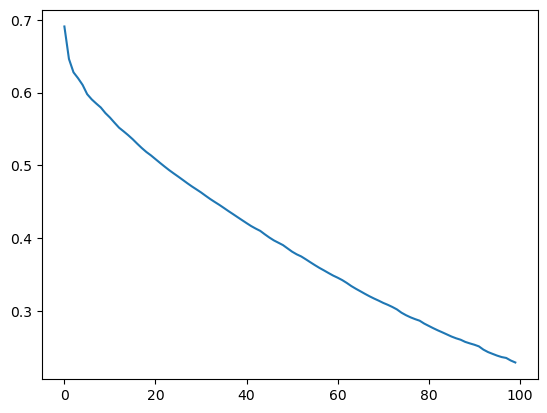

In [53]:
plt.plot(train_losses)

In [54]:
# inference
nn_augmented_full.eval()
y_test_pred = nn.Sigmoid()(nn_augmented_full(test_features_tensor.to(dtype=torch.float32)))
y_test_pred.shape

torch.Size([216, 1])

In [55]:
predictions = y_test_pred.detach().numpy().reshape(-1)
predictions.shape

(216,)

In [56]:
auroc = roc_auc_score(test_y, predictions)
auprc = average_precision_score(test_y, predictions)
print(f"AUROC: {auroc}, AUPRC: {auprc}")

AUROC: 0.5135106828655216, AUPRC: 0.7194730470304438


In [57]:
# per drug
res_df = pd.DataFrame(predictions, columns=["y_pred"])
res_df["y_true"] = test_y
res_df["drug"] = drugs

In [58]:
res_df

,y_pred,y_true,drug
0,0.707562,1,METHOTREXATE
1,0.802374,1,VINBLASTINE
2,0.952002,1,DOXORUBICIN
3,0.939303,1,CISPLATIN
4,0.888771,0,GEMCITABINE
...,...,...,...
211,0.640853,1,PACLITAXEL
212,0.925635,0,PACLITAXEL
213,0.927840,1,CISPLATIN
214,0.798506,1,PACLITAXEL


In [59]:
for d in res_df.drug.unique():
    try:
        subset_df = res_df[res_df.drug == d]
        auroc = roc_auc_score(subset_df["y_true"], subset_df["y_pred"])
        auprc = average_precision_score(subset_df["y_true"], subset_df["y_pred"])
        print(f"Drug {d} | AUROC = {auroc}, AUPRC = {auprc}")
        print(subset_df.shape)
        print(subset_df.y_true.value_counts())
    except:
        continue

Drug METHOTREXATE | AUROC = 1.0, AUPRC = 1.0
(2, 3)
y_true
1    1
0    1
Name: count, dtype: int64
Drug VINBLASTINE | AUROC = 1.0, AUPRC = 1.0
(2, 3)
y_true
1    1
0    1
Name: count, dtype: int64
Drug DOXORUBICIN | AUROC = 0.5151515151515151, AUPRC = 0.8605505605505606
(14, 3)
y_true
1    11
0     3
Name: count, dtype: int64
Drug CISPLATIN | AUROC = 0.506896551724138, AUPRC = 0.7884475101233018
(39, 3)
y_true
1    29
0    10
Name: count, dtype: int64
Drug GEMCITABINE | AUROC = 0.5555555555555556, AUPRC = 0.5814814814814815
(12, 3)
y_true
0    6
1    6
Name: count, dtype: int64
Drug PACLITAXEL | AUROC = 0.47555555555555556, AUPRC = 0.6966144508202937
(34, 3)
y_true
1    25
0     9
Name: count, dtype: int64
Drug 5-FLUOROURACIL | AUROC = 0.37222222222222223, AUPRC = 0.6742790459782573
(29, 3)
y_true
1    20
0     9
Name: count, dtype: int64
Drug CYCLOPHOSPHAMIDE | AUROC = 0.59375, AUPRC = 0.936721040397511
(18, 3)
y_true
1    16
0     2
Name: count, dtype: int64
Drug DOCETAXEL | AUROC = 